In [3]:
PROJECT_FOLDER = '/content/drive/MyDrive/ColabNotebooks/!_ml_start_karpov/'

def connect_gdrive(PROJECT_FOLDER):
    from google.colab import drive
    import os

    drive.mount('/content/drive')
    os.chdir(PROJECT_FOLDER)
    print('Now current folder is: ', os.getcwd())

connect_gdrive(PROJECT_FOLDER)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Now current folder is:  /content/drive/MyDrive/ColabNotebooks/!_ml_start_karpov


## Import libs

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from numpy.linalg import matrix_rank
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SequentialFeatureSelector

import matplotlib.pyplot as plt

In [5]:
processed_data = pd.read_csv('./data/feature_selection/processed_data.csv', index_col='id')
initial_data = pd.read_csv('./data/feature_selection/taxi_dataset.csv')
initial_data = initial_data.set_index('id')
# processed_data.head(3)

In [6]:
processed_data = pd.merge(processed_data, initial_data['pickup_datetime'],
                          left_index=True, right_index=True)

In [7]:
processed_data['pickup_datetime'] = pd.to_datetime(processed_data['pickup_datetime'])

processed_data['date'] = processed_data.pickup_datetime.dt.date
processed_data['day_of_week'] = processed_data.pickup_datetime.dt.dayofweek
processed_data['hour'] = processed_data.pickup_datetime.dt.hour
processed_data['month'] = processed_data.pickup_datetime.dt.month

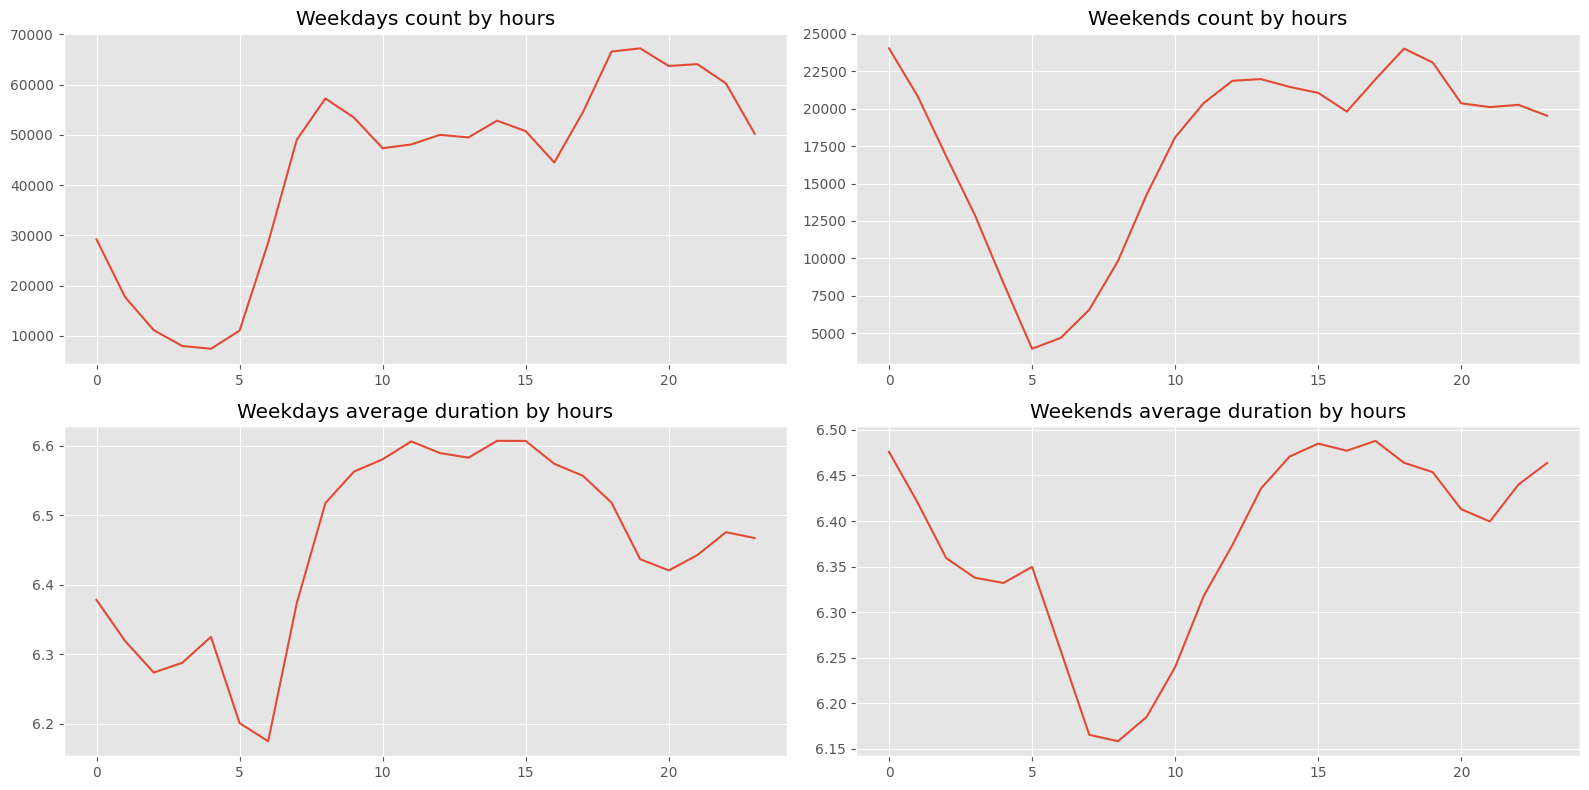

In [6]:
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(16, 8)

ax_1 = fig.add_subplot(2, 2, 1)
weekdays = processed_data[processed_data['day_of_week'].isin([0, 1, 2, 3, 4, ])]
plt.plot(weekdays.groupby(['hour'])['log_trip_duration'].agg('count'))

ax_2 = fig.add_subplot(2, 2, 2)
weekends = processed_data[processed_data['day_of_week'].isin([5, 6 ])]
plt.plot(weekends.groupby(['hour'])['log_trip_duration'].agg('count'))

ax_1.set(title='Weekdays count by hours')
ax_2.set(title='Weekends count by hours')

ax_3 = fig.add_subplot(2, 2, 3)
weekdays = processed_data[processed_data['day_of_week'].isin([0, 1, 2, 3, 4, ])]
plt.plot(weekdays.groupby(['hour'])['log_trip_duration'].agg('mean'))

ax_4 = fig.add_subplot(2, 2, 4)
weekends = processed_data[processed_data['day_of_week'].isin([5, 6 ])]
plt.plot(weekends.groupby(['hour'])['log_trip_duration'].agg('mean'))

ax_3.set(title='Weekdays average duration by hours')
ax_4.set(title='Weekends average duration by hours')
fig.tight_layout()
plt.show()

In [ ]:
agg_data = pd.DataFrame({
    'weekdays_count': weekdays.groupby(['hour'])['log_trip_duration'].agg('count'), 
    'weekends_count': weekends.groupby(['hour'])['log_trip_duration'].agg('count'),
    'weekdays_mean': weekdays.groupby(['hour'])['log_trip_duration'].agg('mean'),
    'weekends_mean': weekends.groupby(['hour'])['log_trip_duration'].agg('mean'),
    'weekdays_sum_duration': weekdays.groupby(['hour'])['log_trip_duration'].agg('sum'),
    'weekends_sum_duration': weekends.groupby(['hour'])['log_trip_duration'].agg('sum'),
    
})

# agg_data.head(3)

In [11]:
# agg_data.corr()

,weekdays_count,weekends_count,weekdays_mean,weekends_mean,weekdays_sum_duration,weekends_sum_duration
weekdays_count,1.000000,0.503663,0.698462,0.144312,0.999502,0.498721
weekends_count,0.503663,1.000000,0.620511,0.719567,0.513588,0.999523
weekdays_mean,0.698462,0.620511,1.000000,0.198568,0.719823,0.610651
weekends_mean,0.144312,0.719567,0.198568,1.000000,0.148656,0.739154
weekdays_sum_duration,0.999502,0.513588,0.719823,0.148656,1.000000,0.508401
weekends_sum_duration,0.498721,0.999523,0.610651,0.739154,0.508401,1.000000


In [ ]:
# processed_data.info()

## Anomaly date - Blizzard

In [ ]:
# processed_data.groupby('date')['log_trip_duration'].agg('count')[15:30]

In [8]:
processed_data['date'] = pd.to_datetime(processed_data['date'])
processed_data['anomaly'] = processed_data.apply(lambda x: 1 if x['date'] == '2016-01-23' else 0 , axis = 1)

## Traffic Jam weekdays and hours

In [9]:
top_pairs = processed_data.\
    groupby(['day_of_week', 'hour'])['log_trip_duration'].\
    agg(['mean']).\
    sort_values(by='mean', ascending=False)[:10].\
    reset_index()[['day_of_week', 'hour']]
top_pairs['top_key'] = top_pairs['day_of_week'].astype(str) + '_' + top_pairs['hour'].astype(str)

processed_data['top_key'] = processed_data['day_of_week'].astype(str) + '_' + processed_data['hour'].astype(str)


processed_data['traffic_jam'] = processed_data.apply(lambda x: 1 if x['top_key'] in list(top_pairs['top_key'].values) else 0, axis=1)

processed_data.drop([
    'top_key', 
    'pickup_datetime', 
    'date',
    ], axis=1, inplace=True)

## OneHotEncoding

In [10]:
encoder = OneHotEncoder(
    sparse=False, 
    drop='first',
    dtype='int64',
)

columns = [
    'day_of_week',
    'hour',
    'month',
]

encoded_data = encoder.fit_transform(processed_data[columns])

df_encoded = pd.DataFrame(
    encoded_data, 
    columns=encoder.get_feature_names_out(),
    index=processed_data.index
)

df = pd.concat([processed_data, df_encoded], axis=1)

df.drop(labels=columns, axis=1, inplace=True)

df.head(5).to_csv('./data/feature_selection/processed_head.csv', sep=',')

df.head()

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,930.399753,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,930.399753,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [66]:
# df.assign(temp_f=lambda x: x.temp_c * 9 / 5 + 32
# lambda x: True if x % 2 == 0 else False

# Error:
# processed_data.assign(blizzard_day = lambda x: 1 if x['date'] == "2016-01-23" else 0, axis = 1)


# processed_data[processed_data['date'].strftime('%Y-%m-%d') == '2016-01-23']
# df[df['Date']. dt. strftime('%Y-%m')=='2021-11']

# processed_data[processed_data['date'].dt.


# convert to dates
# processed_data['date'] = pd.to_datetime(processed_data['date'])
# processed_data.info()
# processed_data[processed_data.date == '2016-01-23']
# processed_data['storm_day'] = processed_data.date == '2016-01-23'

# processed_data.head(3)
# processed_data[processed_data['storm_day'] == True]

# processed_data.drop(['storm_day'], axis=1, inplace=True)

# processed_data['anomaly'] = processed_data.apply(lambda x: 1 if x['date'] == '2016-01-23' else 0 , axis = 1)
# list(top_pairs['top_key'].values)

# processed_data['top-key'] = processed_data['day_of_week'].astype(str) + '-' + processed_data['hour'].astype(str)

# processed_data['top-key'].head(5)

# processed_data['traffic_jam'] = processed_data.apply(lambda x: 1 if x['top-key'] in list(top_pairs['top_key'].values) else 0, axis=1)

# columns = [
#     'day_of_week',
#     'hour',
#     'month',
# ]
# for col in columns:
#     pass




In [139]:
df[['passenger_count', 'distance_km']].corr()

,passenger_count,distance_km
passenger_count,1.000000,0.016596
distance_km,0.016596,1.000000


## Selecting Variables for model by 'SequentialFeatureSelector'

In [12]:
model = LinearRegression()

potential_variables = [
    'distance_km', 
    'anomaly',
    'traffic_jam',
    'day_of_week_2',
    'day_of_week_5',
    'day_of_week_6',
    'hour_3',
    'hour_5',
    'hour_6',
    # 'month_1',
    'month_3',
]

X = df[potential_variables].copy()
y = df['log_trip_duration'].copy()

X.head()

,distance_km,anomaly,traffic_jam,day_of_week_2,day_of_week_5,day_of_week_6,hour_3,hour_5,hour_6,month_3
id,,,,,,,,,,
id2875421,1.500479,0,0,0,0,0,0,0,0,1
id2377394,1.807119,0,0,0,0,1,0,0,0,0
id3858529,6.392080,0,1,0,0,0,0,0,0,0
id3504673,1.487155,0,0,1,0,0,0,0,0,0
id2181028,1.189925,0,0,0,1,0,0,0,0,1


In [14]:
sfs = SequentialFeatureSelector(model, n_features_to_select=5)
sfs.fit(X, y)

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=5)

In [15]:
sfs.get_feature_names_out()

array(['distance_km', 'traffic_jam', 'day_of_week_6', 'hour_5', 'hour_6'],
      dtype=object)

In [16]:
sfs.get_support()

array([ True, False,  True, False, False,  True, False,  True,  True,
       False])

In [23]:
key_variables = ['distance_km', 'traffic_jam', 'day_of_week_6', 'hour_5', 'hour_6']

X_2 = X[key_variables].copy()

model_2 = LinearRegression()
model_2.fit(X_2, y)

LinearRegression()

In [24]:
model_2.predict(X_2)

array([6.27596083, 6.18032465, 6.97801371, ..., 6.5938765 , 6.23228179,
       6.23675688])

In [25]:
mean_squared_error(y, model_2.predict(X_2))

0.41540002340782545